In [491]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [492]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.  # landing platform height
w1 = [-PLATFORM_WIDTH, PLATFORM_WIDTH]
w2 = [0.1*-PLATFORM_WIDTH, 0.1*PLATFORM_WIDTH]
h = [PLATFORM_HEIGHT, PLATFORM_HEIGHT]
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [493]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1)

        return state

In [494]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [495]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, n):
        super(Simulation, self).__init__()
        self.T = T
        self.state = self.initialize_state(n)
        self.controller = controller
        self.dynamics = dynamics
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state,n):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state,n)

    @staticmethod
    def initialize_state(n):
        print('ini',n)
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [0.5*math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*random.random()+1, -0.1*random.random()]  # vertical state
        print('Generate %d initial states of rocket:' % n)
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state, n):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.]) # weight of each state
        return states.sum(dim=0)/n

In [496]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self,n):
        def closure():
            loss = self.simulation(self.simulation.state,n)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch, n):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        print('Start Training:')
        while error > eps and epoch <= max_epoch:
            loss = self.step(n)
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.6f' % (epoch, loss))
            error = loss.item()
        #     cord = self.visualize()
        # print('Landing Trajectory:')
        # for r in range(N):
        #     plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
        #     plt.quiver(cord[-1,r, 2], cord[-1,r, 4], -0.05*np.sin(cord[-1,r, 0]), 0.05*np.cos(cord[-1,r, 0]),color='orange')
        #     plt.plot(w1, h, color="red", linewidth=3)
        #     plt.plot(w2, h, color="green", linewidth=3)
        #     plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4],s=5)
        plt.plot(w1, h, color="red", linewidth=3)
        plt.plot(w2, h, color="green", linewidth=3)
        plt.show()
        return data

In [497]:
class Evaluation:
    def __init__(self, simulation):
        self.simulation = simulation

    def test(self, n):
        print('Start Testing:')
        loss = self.simulation(self.simulation.state,n)
        print('loss: %.6f' % loss)
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        print('Landing Trajectory:')
        for r in range(n):
            plt.quiver(data[:,r, 2], data[:,r, 4], -0.05*np.sin(data[:,r, 0]), 0.05*np.cos(data[:,r, 0]))
            plt.quiver(data[-1,r, 2], data[-1,r, 4], -0.05*np.sin(data[-1,r, 0]), 0.05*np.cos(data[-1,r, 0]),color='orange')
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.show()
            end = data[-1,r,:]
            print(np.abs(end))

ini 100
Generate 100 initial states of rocket:
[[-5.68509052e-01 -6.83906079e-02  3.19316458e-01 -3.02878235e-02
   1.41593090e+00 -7.19579417e-02]
 [ 3.11883295e-01  2.42519554e-02  2.14780640e-01 -3.35064458e-02
   1.25523397e+00 -5.60584842e-02]
 [ 1.90559954e-02 -3.37378733e-02 -8.13686239e-02  1.30704172e-02
   1.16195410e+00 -2.41295317e-03]
 [-6.13932047e-01 -1.08606991e-01 -4.70771342e-01  2.60081143e-02
   1.35787840e+00 -2.40671646e-02]
 [ 1.95824659e-01 -1.42672804e-01  3.22904487e-01 -9.14522496e-03
   1.07068602e+00 -2.61548027e-02]
 [-4.72141998e-01 -1.48804280e-01 -3.38125548e-01  2.93357110e-02
   1.19396444e+00 -6.88184933e-02]
 [ 6.65936584e-01  1.43173195e-01 -3.18362663e-02  2.60677443e-02
   1.35877033e+00 -2.69485921e-02]
 [ 2.23805832e-01 -9.19249959e-02 -4.25332462e-01 -1.17566605e-02
   1.26888094e+00 -3.17927933e-02]
 [ 7.24123978e-01  8.78887360e-02  2.60306581e-01  3.70800992e-02
   1.02057578e+00 -2.11715366e-02]
 [-4.33248899e-02  9.79774423e-02 -3.5385166

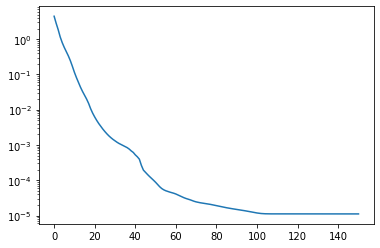

In [498]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 100  # number of initial states
err = 0.001 # acceptable_error
itr = 150 # max_iteration
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err**2,itr,N)  # solve the optimization problem

path = './Landing_Model.pth' # save model
t.save(c.state_dict(),path)

ini 10
Generate 10 initial states of rocket:
[[-5.82844280e-01  6.76618441e-02 -2.31313191e-01  4.02975000e-02
   1.43296928e+00 -5.07770068e-02]
 [-6.37775961e-01 -9.09237718e-02 -6.30059414e-03 -6.50488160e-04
   1.05106443e+00 -1.87501758e-02]
 [-4.74051021e-02  6.14653952e-02  5.90102388e-02  3.67121599e-02
   1.29006065e+00 -4.24112963e-02]
 [-1.33570751e-01  5.82636401e-02 -3.94239830e-01  4.33142810e-02
   1.17253198e+00 -3.88255365e-02]
 [ 6.54246974e-01 -9.48340370e-03 -1.28377394e-01  2.15363283e-02
   1.12013187e+00 -5.74244790e-02]
 [ 7.01499544e-01 -1.56958581e-01 -4.05664691e-01  4.70357145e-02
   1.22654566e+00 -2.42394412e-02]
 [-6.55657669e-01  3.73855779e-02  1.46136559e-01 -3.62378828e-02
   1.26876365e+00 -5.51003925e-02]
 [ 1.64110999e-01  1.32736638e-01 -1.35012108e-01  1.78294156e-02
   1.37231903e+00 -7.64465507e-02]
 [-1.17215949e-01  7.47363022e-03  4.64627079e-01 -8.32409723e-03
   1.21724180e+00 -6.56349828e-02]
 [ 5.88383047e-01 -1.32928670e-01 -3.21350101e

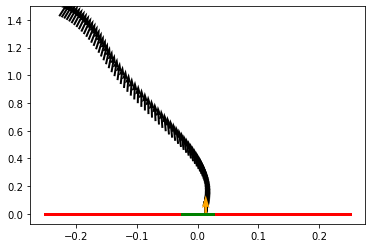

[2.42831011e-04 1.37218938e-03 1.33503769e-02 3.15994606e-04
 2.67306532e-05 1.06706284e-04]


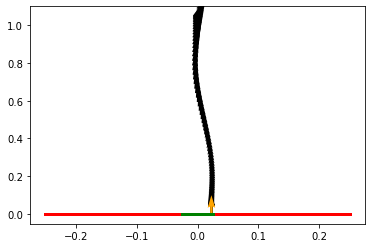

[0.00158445 0.00090471 0.02271278 0.00017171 0.0003449  0.00057324]


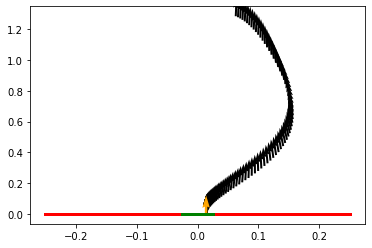

[0.00081931 0.00020293 0.01396341 0.00024628 0.00021322 0.00027172]


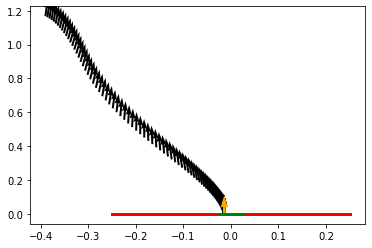

[0.00027621 0.00064251 0.01398265 0.00054486 0.00037957 0.00049694]


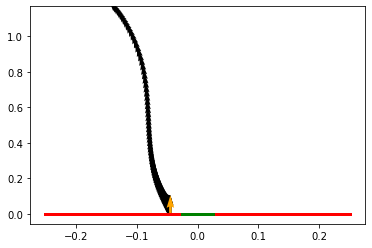

[0.00045635 0.00089563 0.04472357 0.00157392 0.00021482 0.00046807]


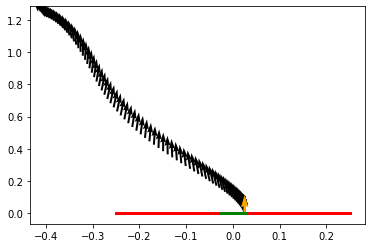

[0.00100241 0.00111313 0.02524508 0.00023532 0.00036254 0.0015397 ]


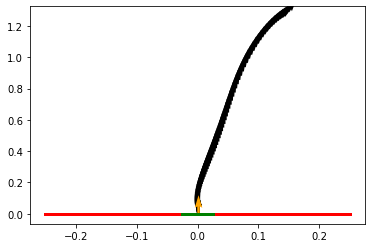

[0.00105016 0.00099949 0.00155945 0.00013613 0.00030944 0.00083265]


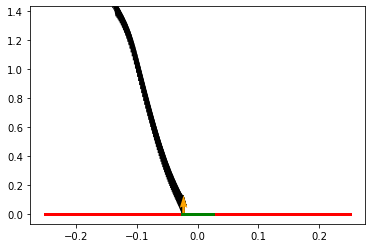

[6.5723713e-04 1.6212719e-04 2.3107389e-02 5.6254707e-04 8.1593847e-05
 8.1798062e-06]


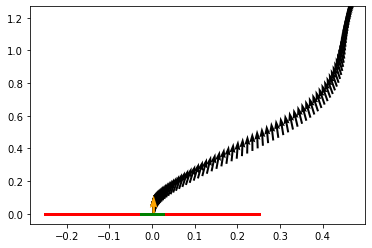

[0.00044218 0.00118372 0.00376359 0.00051769 0.00033055 0.00045778]


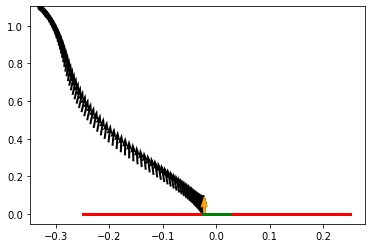

[2.8228373e-03 4.2042631e-04 2.2123449e-02 1.4172763e-03 1.3289592e-05
 3.9633457e-04]


In [499]:
# Test the control model by some new samples:

N_eval = 10 # number of initial states for testing
d_eval = Dynamics()  # define dynamics
model_eval =  Controller(dim_input, dim_hidden1, dim_hidden2, dim_output) # define controller

path = './Landing_Model.pth' # load model
model_eval.load_state_dict(t.load(path))
model_eval.eval()

s_eval = Simulation(model_eval, d_eval, T, N_eval )
eva = Evaluation(s_eval)  # initial evaluation simulator
eva.test(N_eval) # Test